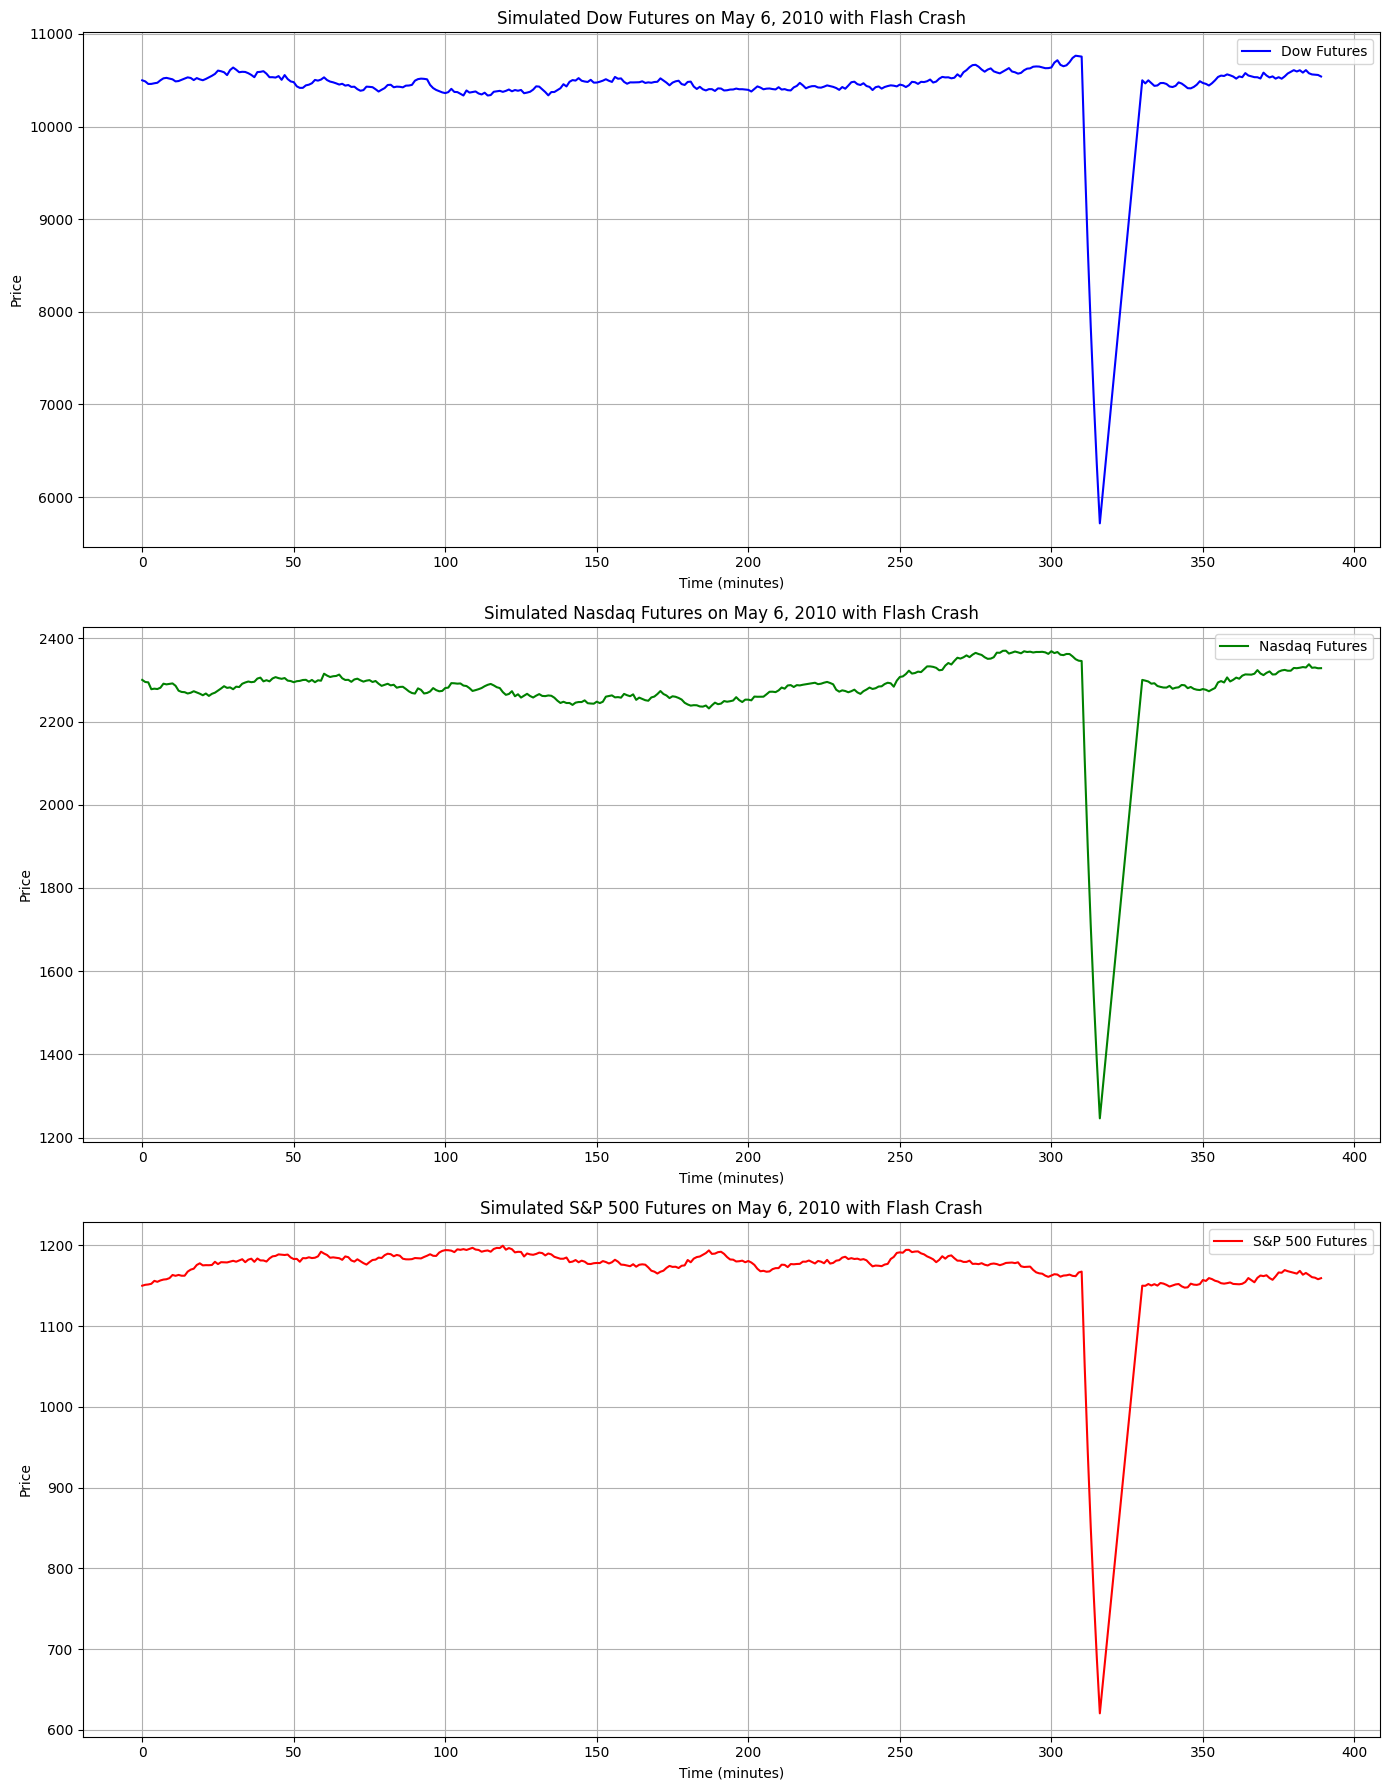

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False

# Define the trading day in minutes (from 9:30 AM to 4:00 PM)
trading_minutes = 390
time_period = np.arange(0, trading_minutes, 1)  # 0 to 389 minutes

# Initial prices (hypothetical values)
initial_price_dow = 10500
initial_price_nasdaq = 2300
initial_price_sp500 = 1150

# Create arrays to store the simulated prices
prices_dow = np.zeros(len(time_period))
prices_nasdaq = np.zeros(len(time_period))
prices_sp500 = np.zeros(len(time_period))

# Set the initial prices
prices_dow[0] = initial_price_dow
prices_nasdaq[0] = initial_price_nasdaq
prices_sp500[0] = initial_price_sp500

# Parameters for normal trading (random walk)
mean_return = 0.0001  # Mean return per minute
volatility = 0.002  # Volatility per minute

# Simulate normal trading for the entire day with the flash crash
for i in range(1, len(time_period)):
    if 311 <= i <= 316:  # Flash crash period (2:41 PM to 2:46 PM, minutes 311 to 316)
        prices_dow[i] = prices_dow[i - 1] * 0.90  # 10% drop
        prices_nasdaq[i] = prices_nasdaq[i - 1] * 0.90  # 10% drop
        prices_sp500[i] = prices_sp500[i - 1] * 0.90  # 10% drop
    elif i > 316 and i <= 330:  # Recovery phase until 3:00 PM (minute 330)
        prices_dow[i] = prices_dow[i - 1] + (initial_price_dow - prices_dow[316]) / (330 - 316)
        prices_nasdaq[i] = prices_nasdaq[i - 1] + (initial_price_nasdaq - prices_nasdaq[316]) / (330 - 316)
        prices_sp500[i] = prices_sp500[i - 1] + (initial_price_sp500 - prices_sp500[316]) / (330 - 316)
    else:  # Normal trading
        prices_dow[i] = prices_dow[i - 1] * (1 + np.random.normal(mean_return, volatility))
        prices_nasdaq[i] = prices_nasdaq[i - 1] * (1 + np.random.normal(mean_return, volatility))
        prices_sp500[i] = prices_sp500[i - 1] * (1 + np.random.normal(mean_return, volatility))

# Plot the simulated prices in three separate graphs
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 18))

# Dow Futures
ax1.plot(time_period, prices_dow, label='Dow Futures', color='blue')
ax1.set_xlabel('Time (minutes)')
ax1.set_ylabel('Price')
ax1.set_title('Simulated Dow Futures on May 6, 2010 with Flash Crash')
ax1.legend()
ax1.grid(True)

# Nasdaq Futures
ax2.plot(time_period, prices_nasdaq, label='Nasdaq Futures', color='green')
ax2.set_xlabel('Time (minutes)')
ax2.set_ylabel('Price')
ax2.set_title('Simulated Nasdaq Futures on May 6, 2010 with Flash Crash')
ax2.legend()
ax2.grid(True)

# S&P 500 Futures
ax3.plot(time_period, prices_sp500, label='S&P 500 Futures', color='red')
ax3.set_xlabel('Time (minutes)')
ax3.set_ylabel('Price')
ax3.set_title('Simulated S&P 500 Futures on May 6, 2010 with Flash Crash')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()


In [8]:
plt.rcParams['text.usetex'] = False

In [9]:
import numpy as np

# Define log-return function
def log_return(prices):
    return np.log(prices[1:] / prices[:-1])

# Simulated prices for each future
prices_dow = [initial_price_dow] + list(prices_dow)
prices_nasdaq = [initial_price_nasdaq] + list(prices_nasdaq)
prices_sp500 = [initial_price_sp500] + list(prices_sp500)

# Calculate log-returns
log_returns_dow = log_return(np.array(prices_dow))
log_returns_nasdaq = log_return(np.array(prices_nasdaq))
log_returns_sp500 = log_return(np.array(prices_sp500))

# Combine into 3-dimensional vectors
log_returns = np.vstack((log_returns_dow, log_returns_nasdaq, log_returns_sp500)).T


In [10]:
import numpy as np
import pandas as pd

log_returns = pd.DataFrame(log_returns)

# Placeholder function to simulate the persistence landscape
def persistence_landscape(time_series):
    # This is a placeholder. Replace with actual computation.
    # For demonstration, we'll just use an array of absolute values of time_series
    return np.abs(time_series)

# Function to calculate the Lp-norm of the persistence landscape
def persistence_landscape_lp_norm(time_series, p=1):
    landscape = persistence_landscape(time_series)
    # Assuming landscape is a 2D array with dimensions (k, len(time_series))
    lp_norm = np.sum(np.sum(np.abs(landscape) ** p, axis=1)) ** (1/p)
    return lp_norm

w = 50

# Construct 3-dimensional time series
time_series_list = []
for t in range(w, len(log_returns)):
    time_series_list.append(log_returns.iloc[t-w:t].values)

# Compute Lp-norm of persistence landscape
p = 1  # You can adjust p as needed
lp_norms = np.array([persistence_landscape_lp_norm(ts, p) for ts in time_series_list])

# Function to compute exponential moving average
def exponential_moving_average(data, alpha=0.1):
    ema = np.zeros_like(data)
    ema[0] = data[0]
    for i in range(1, len(data)):
        ema[i] = alpha * data[i] + (1 - alpha) * ema[i-1]
    return ema

# Function to compute exponential moving variance
def exponential_moving_variance(data, ema, alpha=0.1):
    emvar = np.zeros_like(data)
    emvar[0] = 0  # Starting with zero variance
    for i in range(1, len(data)):
        emvar[i] = alpha * (data[i] - ema[i-1])**2 + (1 - alpha) * emvar[i-1]
    return emvar

# Compute EMA and EMVar
alpha = 0.1  # smoothing factor, adjust as needed
ema = exponential_moving_average(lp_norms, alpha)
emvar = exponential_moving_variance(lp_norms, ema, alpha)

# Compute the abnormality measure Zt
z_t = (lp_norms[w:] - ema[:-w]) / np.sqrt(emvar[:-w])

# Combine results into a DataFrame for better visualization
results = pd.DataFrame({
    'Lp_norm': lp_norms,
    'EMA': ema,
    'EMVar': emvar,
    'Z_t': np.concatenate((np.zeros(w), z_t))  # Adding zeros to match the original index length
}, index=log_returns.index[w:])

print(results)


      Lp_norm       EMA     EMVar       Z_t
50   0.245474  0.245474  0.000000  0.000000
51   0.249111  0.245838  0.000001  0.000000
52   0.250429  0.246297  0.000003  0.000000
53   0.252045  0.246872  0.000006  0.000000
54   0.248844  0.247069  0.000006  0.000000
..        ...       ...       ...       ...
385  0.263089  0.987950  1.313606 -2.483981
386  0.266836  0.915838  1.234246 -2.623689
387  0.267812  0.851036  1.152815 -2.773682
388  0.267487  0.792681  1.071587 -2.933326
389  0.267764  0.740189  0.991982 -3.100951

[340 rows x 4 columns]


/var/folders/2q/51x9q4gj36z79hdwz7zwxz0w0000gn/T/ipykernel_37725/3855974908.py:52: RuntimeWarning: divide by zero encountered in divide
  z_t = (lp_norms[w:] - ema[:-w]) / np.sqrt(emvar[:-w])


In [11]:
print(f"Max Z_t: {z_t.max()}")
print(f"Max Lp norm: {lp_norms.max()}")

Max Z_t: 472.37966983007067
Max Lp norm: 3.887172259747763


In [14]:
len_prices = len(prices_sp500)
len_z_t = len(z_t)
if len_prices > len_z_t:
    padded_z_t = np.concatenate([z_t, np.zeros(len_prices - len_z_t)])
    padded_prices_sp500 = np.array(prices_sp500)
else:
    padded_z_t = np.array(z_t)
    padded_prices_sp500 = np.concatenate([prices_sp500, np.zeros(len_z_t - len_prices)])


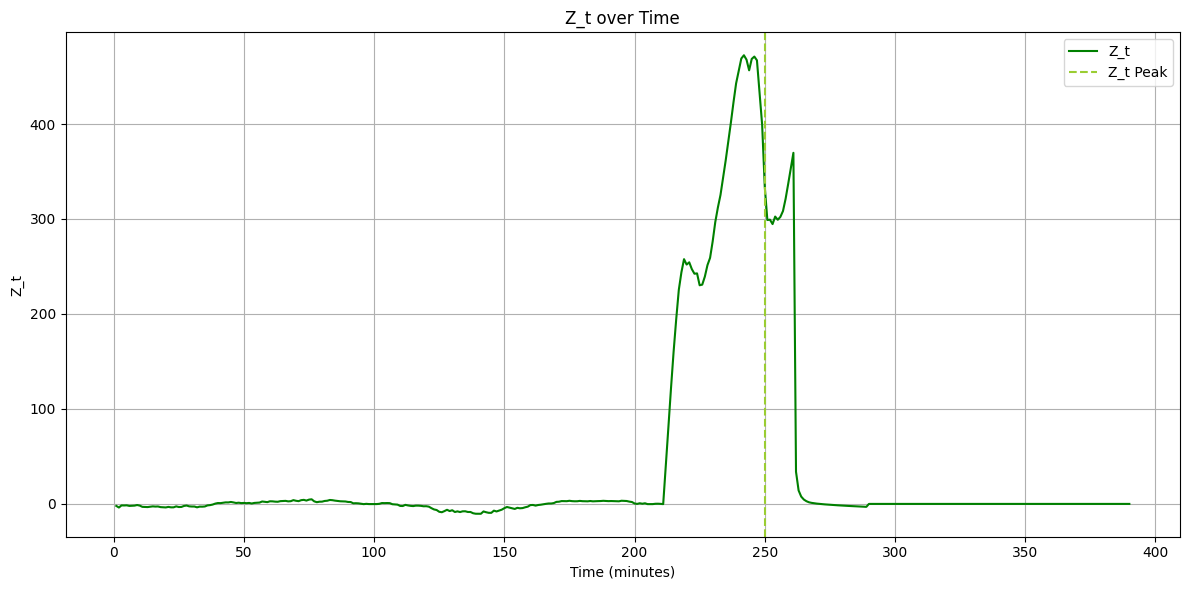

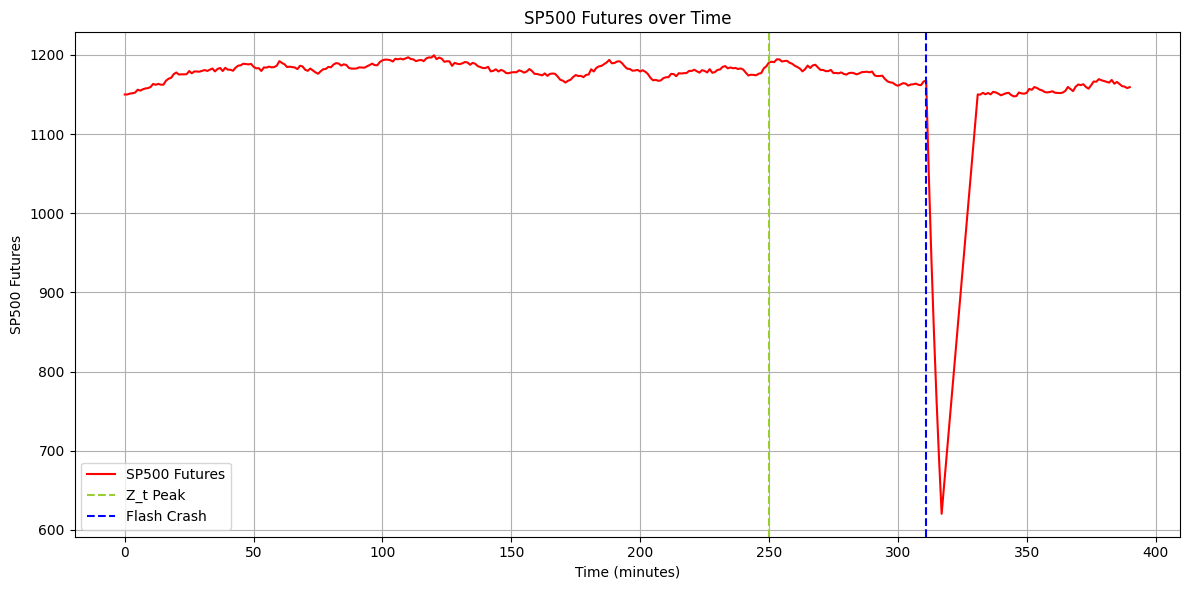

In [16]:
# Find the peak of Z_t
zt_peak_time = 250
flash_crash_time = 311
# Plot Z_t over time
plt.figure(figsize=(12, 6))
plt.plot(padded_z_t, label='Z_t', color='green')
plt.axvline(x=zt_peak_time, color='yellowgreen', linestyle='--', label='Z_t Peak')
plt.title('Z_t over Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Z_t')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot SP500 over time
plt.figure(figsize=(12, 6))
plt.plot(padded_prices_sp500, label='SP500 Futures', color='red')
plt.axvline(x=zt_peak_time, color='yellowgreen', linestyle='--', label='Z_t Peak')
plt.axvline(x=flash_crash_time, color='blue', linestyle='--', label='Flash Crash')
plt.title('SP500 Futures over Time')
plt.xlabel('Time (minutes)')
plt.ylabel('SP500 Futures')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Persistance Diagram


In [18]:
time_series = [log_returns[i-w:i] for i in range(w, len(log_returns))]
Y = np.sum(np.abs(time_series), axis=1)

# Print the shape to verify
print(Y.shape)  # Should output (339, 3)

# Print the resulting matrix
print(Y)



(340, 3)
[[0.08699162 0.08487476 0.07360789]
 [0.08773372 0.08609704 0.07528056]
 [0.09091178 0.08496834 0.07454926]
 ...
 [0.09424893 0.08642432 0.08713842]
 [0.09442518 0.08599136 0.08707082]
 [0.09371219 0.08672173 0.08733012]]


In [19]:
# Function to compute exponential moving average
def exponential_moving_average(data, alpha=0.3):
    ema = np.zeros_like(data)
    ema[0] = data[0]
    for i in range(1, len(data)):
        ema[i] = alpha * data[i] + (1 - alpha) * ema[i-1]
    return ema

# Function to compute exponential moving variance
def exponential_moving_variance(data, ema, alpha=0.3):
    emvar = np.zeros_like(data)
    emvar[0] = 0  # Starting with zero variance
    for i in range(1, len(data)):
        emvar[i] = alpha * (data[i] - ema[i-1])**2 + (1 - alpha) * emvar[i-1]
    return emvar

# Compute EMA and EMVar excluding the first row
EMA = exponential_moving_average(Y[:-1])
EMVar = exponential_moving_variance(Y[1:], EMA[:-1])

In [20]:
Z = np.zeros((339, 3))

for i in range(338):
    for j in range(3):
        if EMVar[i, j] == 0:
            Z[i, j] = 0  # Or np.nan, or some other value indicating invalid data
        else:
            Z[i, j] = (Y[i + 1, j] - EMA[i, j]) / np.sqrt(EMVar[i, j])

# Print the shape to verify
print(Z.shape)  # Should output (339, 3)

# Optionally, print the resulting array
print(Z)


(339, 3)
[[ 0.          0.          0.        ]
 [ 1.72205639 -5.32864226  0.85251766]
 [ 0.67407915 -1.29515127  1.69510551]
 ...
 [-0.18639939 -0.15304011 -0.16793488]
 [-0.1520425  -0.13412804 -0.14073553]
 [ 0.          0.          0.        ]]


In [21]:
rips = Rips()
dgms_torus_persim = rips.fit_transform(Z)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


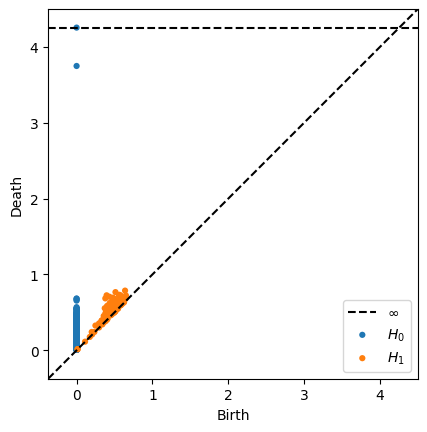

In [22]:
rips.plot(dgms_torus_persim)

<Axes: >

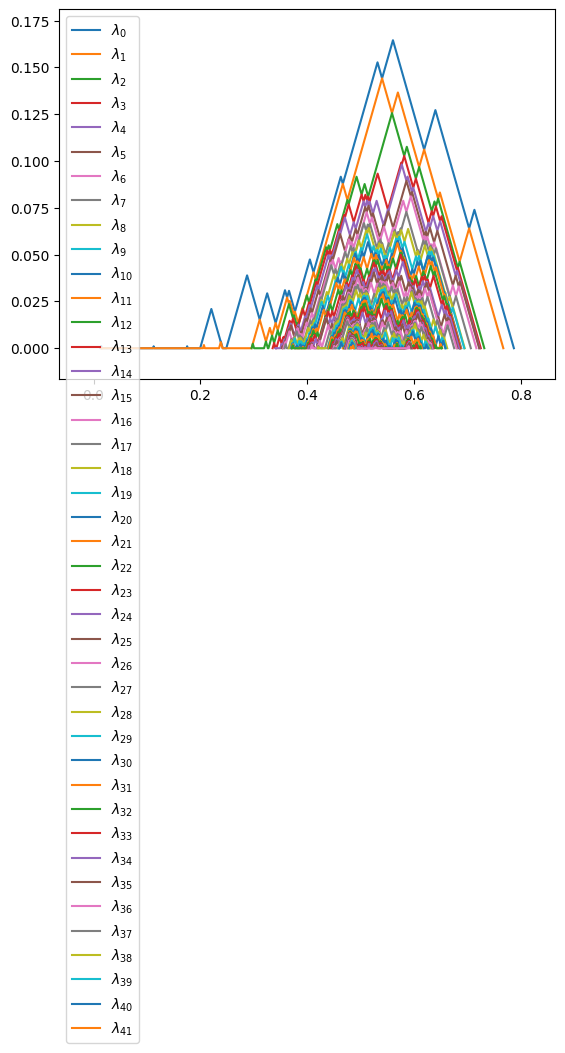

In [23]:
landscapes.plot_landscape_simple(PersLandscapeExact(dgms_torus_persim, hom_deg=1))